In [2]:
import pandas as pd
from pyfaidx import Fasta
from Bio import SeqIO
import matplotlib.pyplot as plt

In [3]:
def process_rna_symbol(symbol):
    # 1. 如果字符串以 novel_ 开头，删除 novel_
    if symbol.startswith("novel_"):
        symbol = symbol[6:] 
    
    # 2. 仅保留包含 'hsa' 的行
    if "hsa" not in symbol and "mmu" not in symbol and "exo" not in symbol:
        return None  # 返回 None 用于之后的行过滤
    
    # 3. 将格式字符串中的piR和hsa调换位置
    parts = symbol.split('-')
    if len(parts) == 3 and parts[0] == "piR":
        symbol = f"hsa-piR-{parts[2]}" 
    
    return symbol

In [4]:
localization_file = '/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/resources/circRNA subcellular localization information.txt'
localization_df = pd.read_csv(localization_file, sep='\t')
localization_df['RNA_Symbol'] = localization_df['RNA_Symbol'].apply(process_rna_symbol)
localization_df = localization_df[localization_df['RNALocate_Score'] >= 0.5]
localization_df.dropna(subset=['RNA_Symbol'], inplace=True)



In [5]:

output_csv = "./output_with_sequences.csv"  # 输出CSV文件

fasta_files = [
    "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/references/circRNA/mouse_mm9_circRNAs_putative_spliced_sequence.fa",
    "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/references/circRNA/hsa_circbase_seq.fa",
    "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/references/circRNA/exo_circRNA_sequences.fa",
]

# 定义函数，解析FASTA文件并提取RNA_Symbol和序列
def parse_fasta(file_path):
    seq_dict = {}
    for record in SeqIO.parse(file_path, "fasta"):
        name = record.id
        sequence = str(record.seq)
        # 根据文件来源处理RNA_Symbol
        if "|" in name:  # 第一个文件
            symbol = name.split("|")[0]
        elif "(" in name:  # 第三个文件
            symbol = name.split("(")[0]
        else:  # 第二个文件
            symbol = name
        seq_dict[symbol] = sequence
    return seq_dict

# 合并所有FASTA文件中的RNA_Symbol和序列
rna_sequences = {}
for fasta in fasta_files:
    rna_sequences.update(parse_fasta(fasta))

# 加载CSV文件


# 根据RNA_Symbol添加Sequence列
localization_df["Sequence"] = localization_df.iloc[:, 2].map(rna_sequences).fillna("Sequence_not_found")



In [6]:
localization_df['Subcellular_Localization'] = localization_df['Subcellular_Localization'].replace({
    'Cytoplasm': 'Cytosol',
    'Extracellular exosome': 'Extracellular vesicle'
})

# 筛选仅保留指定的行
valid_localizations = ['Cytosol', 'Extracellular vesicle', 'Nucleus']
localization_df = localization_df[localization_df['Subcellular_Localization'].isin(valid_localizations)]

In [7]:
localization_df

,RNALocate_ID,Species,RNA_Symbol,RNA_Type,Subcellular_Localization,GO_Accession,PubMed_ID,RNALocate_Score,Sequence
1,RL-E-circ-0938849,Mus musculus,mmu_circ_0000942,circRNA,Cytosol,GO:0005737,34751796.0,0.932913,TTCGAAGGCTGCAAGAAGGCCTTTTCCAGGCTCGAGAACCTCAAGA...
3,RL-E-circ-0938858,Mus musculus,mmu_circ_0009559,circRNA,Cytosol,GO:0005737,38331014.0,0.904945,GTCTTATGGCAGCGTGTACAAGGCTATTCATAAAGAGACTGGCCAG...
4,RL-E-circ-0938860,Mus musculus,mmu_circ_0002373,circRNA,Cytosol,GO:0005737,37913973.0,0.836757,GATGACCAGACTCCACTCCACATCTCAGCCCGACTTGGGAAAGCTG...
5,RL-E-circ-0938888,Mus musculus,mmu_circ_0001572,circRNA,Cytosol,GO:0005737,33995660.0,0.836757,GTTAAAAAATCTCTCTAAGAGCCTGATTTTAGAGTTCACCAGCTCC...
6,RL-E-circ-0938900,Mus musculus,mmu_circ_0000075,circRNA,Cytosol,GO:0005737,36732429.0,0.694506,GATAACCTTGGCGCTCAGTTCAGCCATATGAGTCTTGCCCGCCAGC...
...,...,...,...,...,...,...,...,...,...
134177,RL-E-circ-1072890,Homo sapiens,hsa_circ_0048131,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506,GCCCTGTTTGTGCTCTTCGTCCTGGCCTACATCCACATCGTCTTCT...
134178,RL-E-circ-1072891,Homo sapiens,hsa_circ_0070761,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506,TTCCGTGATGATGGTCTAAGCAAAGACCCTTCGTCCTGTTAAAGAT...
134179,RL-E-circ-1072892,Homo sapiens,hsa_circ_0063332,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.694506,GTTAAGTTGGAGCCGACTCAGCGGCGGCCGCCATTTTGTGCAGTCG...
134180,RL-E-circ-1072893,Homo sapiens,hsa_circ_0000375,circRNA,Extracellular vesicle,GO:1903561,34650036.0,0.795006,GTCCCATCCATGGGGGGGCGGAAGCGGGAGCGCAAGGCTGCCGTCG...


平均序列长度: 1897.57
序列长度分布（按分箱）：
18.0 - 11238.9: 1290 条序列
11238.9 - 22459.7: 5 条序列
22459.7 - 33680.6: 4 条序列
33680.6 - 44901.5: 2 条序列
44901.5 - 56122.3: 0 条序列
56122.3 - 67343.2: 2 条序列
67343.2 - 78564.1: 1 条序列
78564.1 - 89784.9: 0 条序列
89784.9 - 101005.8: 0 条序列
101005.8 - 112226.7: 0 条序列
112226.7 - 123447.5: 0 条序列
123447.5 - 134668.4: 0 条序列
134668.4 - 145889.3: 0 条序列
145889.3 - 157110.1: 0 条序列
157110.1 - 168331.0: 0 条序列
168331.0 - 179551.9: 0 条序列
179551.9 - 190772.7: 0 条序列
190772.7 - 201993.6: 0 条序列
201993.6 - 213214.5: 0 条序列
213214.5 - 224435.3: 0 条序列
224435.3 - 235656.2: 0 条序列
235656.2 - 246877.1: 0 条序列
246877.1 - 258097.9: 0 条序列
258097.9 - 269318.8: 0 条序列
269318.8 - 280539.7: 0 条序列
280539.7 - 291760.5: 0 条序列
291760.5 - 302981.4: 0 条序列
302981.4 - 314202.3: 0 条序列
314202.3 - 325423.1: 0 条序列
325423.1 - 336644.0: 3 条序列


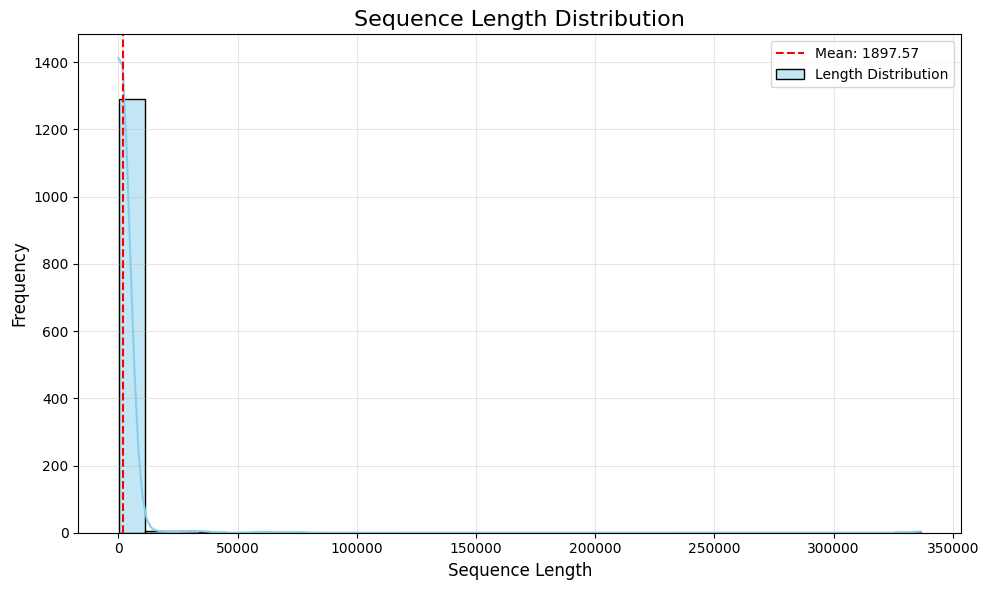

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设 localization_df 已经加载并清理好

# 计算 Sequence 长度
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()

# 统计平均值
average_length = localization_df['Sequence_Length'].mean()
print(f"平均序列长度: {average_length:.2f}")

# 设置分箱区间
bins = np.histogram_bin_edges(localization_df['Sequence_Length'], bins=30)  # 自动生成30个分箱
bin_counts, bin_edges = np.histogram(localization_df['Sequence_Length'], bins=bins)

# 打印每个分箱的序列数量
print("序列长度分布（按分箱）：")
for i in range(len(bin_counts)):
    print(f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {bin_counts[i]} 条序列")

# 绘制分布图
plt.figure(figsize=(10, 6))
sns.histplot(localization_df['Sequence_Length'], bins=bins, kde=True, color='skyblue', label='Length Distribution')

# 添加平均值的标注
plt.axvline(average_length, color='red', linestyle='--', label=f'Mean: {average_length:.2f}')

# 图形细节
plt.title('Sequence Length Distribution', fontsize=16)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# 展示图形
plt.show()

In [9]:
# 检查 'Sequence' 列是否包含 'N'，并删除包含 'N' 的行
original_row_count = len(localization_df)  # 原始行数
localization_df = localization_df[~localization_df['Sequence'].str.contains('N')]  # 保留不包含 'N' 的行
new_row_count = len(localization_df)  # 处理后行数

# 计算删除的行数
deleted_rows = original_row_count - new_row_count

# 打印删除的行数
print(f"删除了 {deleted_rows} 行")


删除了 3 行


In [10]:
# 删除长度过长的circRNA
localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()
original_row_count = len(localization_df)

# 删除 Sequence 长度大于 11238 的行，仍保存于localization_df
localization_df = localization_df[localization_df['Sequence_Length'] <= 11238]
new_row_count = len(localization_df)
deleted_rows = original_row_count - new_row_count
print(f"删除了 {deleted_rows} 行")


删除了 14 行


/tmp/ipykernel_128542/577051431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localization_df['Sequence_Length'] = localization_df['Sequence'].str.len()


Subcellular_Localization
Cytosol                  737
Extracellular vesicle    385
Nucleus                  168
Name: count, dtype: int64


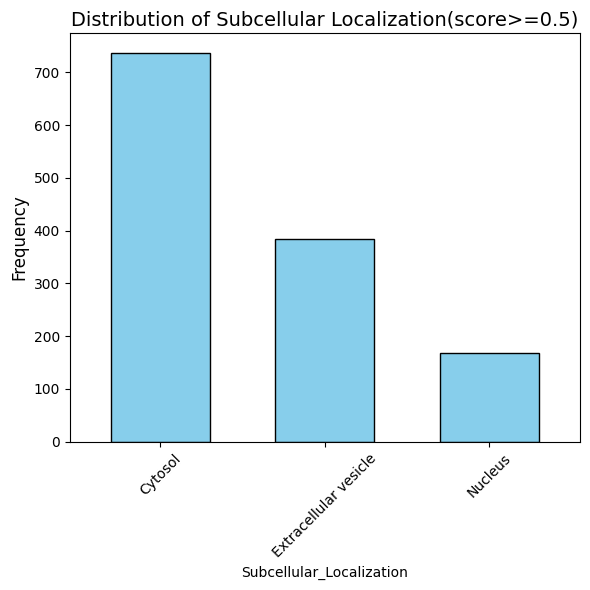

In [15]:
localization_counts = localization_df['Subcellular_Localization'].value_counts()

# 打印每种元素的计数
print(localization_counts)

# 绘制柱状图
plt.figure(figsize=(6, 6))
localization_counts.plot(kind='bar', color='skyblue', edgecolor='black', width = 0.6)

# 添加标题和标签
plt.title('Distribution of Subcellular Localization(score>=0.5)', fontsize=14)
# plt.xlabel('Subcellular Localization', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation = 45)
# 显示图形
plt.tight_layout()
plt.show()

In [12]:
localization_df.to_csv(output_csv, sep="\t", index=False)